In [1]:
epochs = 10
batch_size = 32
dataset_directory_path = './'
saved_weights_path = './bert_wwm_saved_weights.pt'

In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 29.2MB/s 
     |████████████████████████████████| 870kB 46.2MB/s 
     |████████████████████████████████| 3.3MB 35.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=043f299f17f34d6d37f466b96d62234198bbc1e3208c2205d66bcd0773418e10
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

In [4]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
training_set = pd.read_csv("chinese_train.csv").dropna().reset_index(drop=True)
training_texts = training_set['text']
training_labels = training_set['label']

testing_set = pd.read_csv("chinese_test.csv").dropna().reset_index(drop=True)
testing_texts = testing_set['text']
testing_labels = testing_set['label']

validation_set = pd.read_csv("chinese_validate.csv").dropna().reset_index(drop=True)
validation_texts = validation_set['text']
validation_labels = validation_set['label']

training_set.head()

,text,label
0,回复新浪网友对博文国家文物局限制鉴宝节目现场估价转的评论查看原文,1
1,分享网易新闻发生在昆明的火锅店老板辱滇门云南人该愤怒还是羞愧发生在昆明网易新闻客户端网易新闻,1
2,西宁城管围殴民警扬言要把警察打死西宁城管围,1
3,川航航班因驾驶舱风挡破裂安全备降成都今天上午626从重庆江北国际机场出发前往拉萨的四川航空3...,1
4,分享网易新闻湖南道县一按摩店员工因琐事矛盾捅死老板夫妻,1


In [7]:
training_labels.value_counts()

1    10375
0    10304
Name: label, dtype: int64

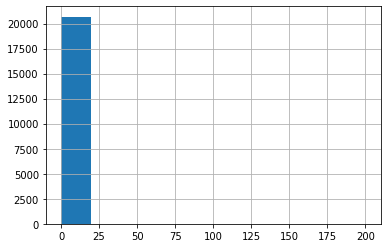

In [8]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in training_texts]

pd.Series(seq_len).hist(range=(0,200))

In [9]:
# For Roberta
from transformers import BertTokenizerFast as TokenizerClass
from transformers import BertForSequenceClassification as ModelClass
model_name = 'hfl/chinese-roberta-wwm-ext'
tokenizer = TokenizerClass.from_pretrained(model_name)
# pt_model = ModelClass.from_pretrained(model_name)
pt_model = ModelClass.from_pretrained(model_name, num_labels=2)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model che

In [10]:
training_encodings = tokenizer(training_texts.tolist(), max_length=25, padding='max_length', truncation=True)
validation_encodings = tokenizer(validation_texts.tolist(), max_length=25, padding='max_length', truncation=True)
testing_encodings = tokenizer(testing_texts.tolist(), max_length=25, padding='max_length', truncation=True)

In [11]:
class CovidDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

training_dataset = CovidDataset(training_encodings, training_labels)
validation_dataset = CovidDataset(validation_encodings, validation_labels)
testing_dataset = CovidDataset(testing_encodings, testing_labels)

In [12]:
from torch.utils.data import DataLoader
training_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=True)

In [13]:
pt_model.to(device)
pt_model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [14]:
# optimizer
from transformers import AdamW

optimizer = AdamW(pt_model.parameters(), lr = 1e-5) # learning rate

In [15]:
def train(model, dataloader):
  print('Training...')
  model.train()
  total_loss = 0
  t0 = time.time()
  for step, batch in enumerate(dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = pt_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  avg_loss = total_loss / len(dataloader)
  return avg_loss

In [16]:
def evaluate(model, dataloader):
  print('Evaluating...')
  model.eval()
  total_loss = 0
  t0 = time.time()
  for step, batch in enumerate(dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dataloader), elapsed))
    optimizer.zero_grad()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = pt_model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    total_loss += loss.item()
    loss.backward()
    optimizer.step()
  avg_loss = total_loss / len(dataloader)
  return avg_loss

In [17]:
training_losses, validation_losses = [], []
best_validation_loss = float('inf')
for epoch in range(epochs):
  print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
  training_loss = train(pt_model, training_loader)
  validation_loss = evaluate(pt_model, validation_loader)
  if validation_loss < best_validation_loss:
    best_validation_loss = validation_loss
    torch.save(pt_model.state_dict(), saved_weights_path)
  training_losses.append(training_loss)
  validation_losses.append(validation_loss)
  print(f'\nAverage training loss: {training_loss:.3f}')
  print(f'Average validation loss: {validation_loss:.3f}\n')

======== Epoch 1 / 10 ========
Training...
  Batch    50  of    647.    Elapsed: 0:00:08.
  Batch   100  of    647.    Elapsed: 0:00:15.
  Batch   150  of    647.    Elapsed: 0:00:23.
  Batch   200  of    647.    Elapsed: 0:00:31.
  Batch   250  of    647.    Elapsed: 0:00:39.
  Batch   300  of    647.    Elapsed: 0:00:46.
  Batch   350  of    647.    Elapsed: 0:00:54.
  Batch   400  of    647.    Elapsed: 0:01:02.
  Batch   450  of    647.    Elapsed: 0:01:10.
  Batch   500  of    647.    Elapsed: 0:01:18.
  Batch   550  of    647.    Elapsed: 0:01:26.
  Batch   600  of    647.    Elapsed: 0:01:34.
Evaluating...
  Batch    50  of    216.    Elapsed: 0:00:08.
  Batch   100  of    216.    Elapsed: 0:00:16.
  Batch   150  of    216.    Elapsed: 0:00:24.
  Batch   200  of    216.    Elapsed: 0:00:33.

Average training loss: 0.261
Average validation loss: 0.129

======== Epoch 2 / 10 ========
Training...
  Batch    50  of    647.    Elapsed: 0:00:08.
  Batch   100  of    647.    Elapsed: 0

In [18]:
import plotly.express as px
f = pd.DataFrame(training_losses)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training Loss of The Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [19]:
f = pd.DataFrame(validation_losses)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Validation Loss of The Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [20]:
#load weights of best model
pt_model.load_state_dict(torch.load(saved_weights_path))

<All keys matched successfully>

In [21]:
# get predictions for test data

with torch.no_grad():
  # empty list to save the model predictions
  total_preds, true_labels = [], []

  # iterate over batches
  for step, batch in enumerate(testing_loader):
    # push the batch to gpu
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = pt_model(input_ids, attention_mask=attention_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    total_preds.append(logits)
    label_ids = labels.to('cpu').numpy()
    true_labels.append(label_ids)

In [22]:
total_preds = np.concatenate(total_preds, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [23]:
len(total_preds)

6897

In [24]:
len(true_labels)

6897

In [25]:
from sklearn.metrics import classification_report
# model's performance
preds = np.argmax(total_preds, axis = 1)
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3436
           1       0.97      0.96      0.96      3461

    accuracy                           0.96      6897
   macro avg       0.96      0.96      0.96      6897
weighted avg       0.96      0.96      0.96      6897



In [26]:
# confusion matrix
pd.crosstab(true_labels, preds)

col_0,0,1
row_0,,
0,3318,118
1,152,3309
